# BLG634E - Homework 4: Epipolar Geometry

###  Bengisu Guresti - 504191557

### In this assignment, you will work on Epipolar Geometry. You will implement the well-known 8-point Algorithm in 3D vision to reconstruct camera poses, and 3D structure (depth) using point correspondences. Load the images (1.JPG and 2.JPG) provided in assignment zip file. In order to work within a calibrated epipolar geometry scenario, we will use the intrinsic camera parameters, which are given in the cube data.mat file. Load the mat file and see the 3x3 intrinsic camera calibration matrix “Calib”. This mat file also contains a set of 45 point correspondences selected where x1 and x2 contain homogeneous point pairs from image 1 and image 2 respectively. You will estimate the rotation and translation (R,T), i.e. the relative camera pose. In addition, you will obtain a point cloud of the 3D structure from a collection of corresponding points from two views of the given object.

## Task 1: 8-pt Algorithm

### Estimate Essential Matrix E by implementing the 8-point algorithm as we learned in class. Do not forget to normalize the image points as we learned before (centroid 0 and variance of distances to centroid/origin normalized to 1). Also, remember to project your essential matrix onto the Space of Essential Matrices.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio

from copy import deepcopy
from mpl_toolkits import mplot3d

%matplotlib inline

Cube images and data are read and loaded:

In [2]:
cube1 = plt.imread("BLG634E-Lab04Data/1.JPG")
cube2 = plt.imread("BLG634E-Lab04Data/2.JPG")
cube_data = sio.loadmat('BLG634E-Lab04Data/cube_data.mat')

First cube image is displayed below:

Text(0.5, 1.0, 'Cube 1')

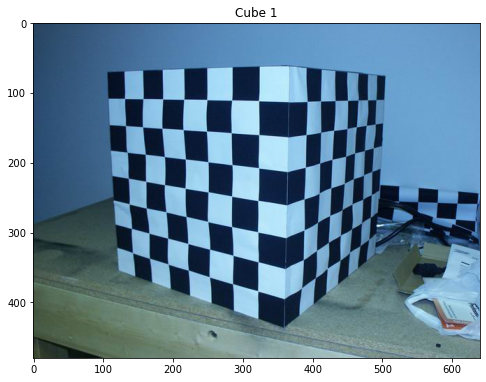

In [3]:
plt.figure(figsize = (8, 10))
plt.imshow(cube1)
plt.title("Cube 1")

Second cube image is displayed below:

Text(0.5, 1.0, 'Cube 2')

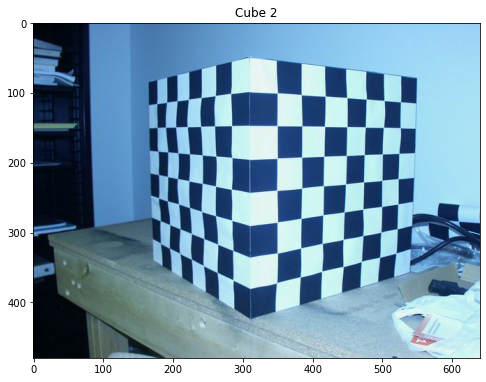

In [4]:
plt.figure(figsize = (8, 10))
plt.imshow(cube2)
plt.title("Cube 2")

Intrinsic camera calibration matrix:

In [5]:
cube_data['Calib']

array([[655.3076,   0.    , 340.311 ],
       [  0.    , 653.5052, 245.3426],
       [  0.    ,   0.    ,   1.    ]])

Intrinsic camera parameters:

Focal lengths: $f_x = 655.3076$ and $f_y = 653.5052$,   
Principle point: $[340.311, 245.3426]$,  
Skew = $0$.

Shapes of image 1 and image 2 correspondence data:

In [6]:
cube_data['x1'].shape, cube_data['x2'].shape

((3, 45), (3, 45))

In [7]:
X1 = cube_data['x1'].T
X2 = cube_data['x2'].T

In [8]:
X1.shape, X2.shape

((45, 3), (45, 3))

Function normalise2Dpts takes a set of points with dimension (N, 3) and normalizes them i.e. makes the origin at the centroid of all the points and mean distance of the points from the centroid is set to $1$ (as instructed in the question instead of $\sqrt2$). This function is used for normalization in normalized 8-point algorithm.

In [9]:
def normalise2Dpts(pts):
    points = deepcopy(pts)
    t_x = points[:, 0].mean()
    t_y = points[:, 1].mean()
    if (points[:, 2] != 1).any():
        # Check if the z coordinate is 1 for all of the points, 
        # if not, set the z coordinate as 1 for all of the points
        points[:, 2] = 1
    points[:, 0] -= t_x
    points[:, 1] -= t_y
    norm_mean = np.sqrt(points[:, 0] ** 2 + points[:, 1] ** 2).mean()
    scale = np.sqrt(1) / norm_mean
    points[:, 0] *= scale
    points[:, 1] *= scale
    T1 = np.array([[1, 0, -t_x],[0, 1, -t_y],[0, 0, 1]])
    T2 = np.array([[scale, 0, 0],[0, scale, 0],[0, 0, 1]])
    T3 = T2 @ T1
    return points, T3

Function to get the kronecker product of source points X1 and destination points X2: 

It first diagonalizes each $x_s, y_s, z_s$ vector for all of the source points such that diagonalized matrix is of size $N \times 3 \times 3$. Then, it expands the destination points such that $N \times 3$ matrix, where N is the number of destination points and 2nd dimension with size 3 are $x_d, y_d, z_d$, becomes an $N \times 3 \times 3$ matrix where N is the number of destination points and 2nd dimension with size 3 has the $x_d, y_d, z_d$ vectors such that each $x, y, z$ vector consists of 3 times repeated elements of $x_d$ / $y_d$ / $z_d$  e.g. $[x_d, x_d, x_d], [y_d, y_d, y_d], [z_d, z_d, z_d]$. Then it batch matrix multiplies the batch expanded destination with batch diagonalized source. Then it flattens each matrix result in the batch matrix (with size $N \times 3 \times 3$) such that the result becomes of size $N \times 9$.

In [10]:
def kronecker_product(src, dst):
    diag_src = np.array(list(map(np.diag, src)))
    wide_dst = np.expand_dims(dst, axis=-1).repeat(3, axis=-1)
    return np.matmul(wide_dst, diag_src).reshape(-1, 9)

Function to estimate Essential matrix E:

It first converts the source coordinates and destination coordinates to their normalized coordinates in terms of the intrinsic camera matrix in order to estimate essential Matrix E by the 8-point algorithm in the calibrated case setup. This normalization according to intrinsic camera matrix is done by matrix multiplying the inverse of the intrinsic camera matrix with the point coordinates e.g. $x = K^{-1}x^{'}$ where $K$ is the intrinsic camera matrix, $x^{i}$ are the point coordinates and $x$ are the normalized point coordinates according to intrinsic camera matrix. Since both points come from images with the same calibrated camera, the same intrinsic matrix is used for source and destination coordinates.

Then in order to perform the normalized 8-point algorithm, the points are further normalized by normalize2Dpts function as described above. Then the kronecker product of final normalized source and destination coordinates are calculated as by kronecker_product function as described above. Then in order to solve for $Ae=0$m linear least squares estimation is performed, and solution is found by taking the last column of $V$ where $V$ is the right singular vector of SVD of $A$ (since numpy returns the transpose of v: $v_t$ last row of $v_t$ is taken as solution). Then the solution is reshaped to form a $3 \times 3$ matrix and denormalized (from the second normalization of normalize2Dpts). Then the normalized estimate of essential matrix is projected onto the Space of Essential Matrices by taking its SVD again, setting its singular values to $[1, 1, 0]$ (although the first derivation of Soatto proposes to set the first 2 singular values to the average of the greatest 2 singular values of first estimate E the algorithm following it sets them to 1). Then the final estimate E is formed by using the new set singular values and extracted left and right singular vectors.

In [11]:
def estimate_E(sources, dests):
    # normalize source coordinates according to intrinsic camera matrix
    x1 = sources @ np.linalg.inv(cube_data['Calib']).T
    # normalize destination coordinates according to intrinsic camera matrix
    x2 = dests @ np.linalg.inv(cube_data['Calib']).T
    # normalize source points and get normalization transformation matrice
    s_pts, s_T3 = normalise2Dpts(x1)
    # normalize destination points and normalization transformation matrice
    t_pts, t_T3 = normalise2Dpts(x2)
    # get the kronecker product of source and destination points to form A
    A = kronecker_product(s_pts, t_pts)
    # apply svd on A to get a solution E which is assumed to be in its null space
    # and is computed by taking the last column of v in u, s, transpose(v) = A
    # Since svd function returns the transpose of v, its last row is taken as the solution.
    u, s, vt = np.linalg.svd(A)
    E = vt[-1].reshape((3, 3))
    E = t_T3.T @ (E @ s_T3)
    # apply svd on E to project E onto the space of essential matrices
    u_E, s_E, vt_E = np.linalg.svd(E)
    # modify the diagonal (of singular values) as necessary
    est_sE = np.array([1, 1, 0])
    # reconstruct estimated essential matrix
    est_E = (u_E * est_sE) @ vt_E
    return est_E

In [12]:
E = estimate_E(X1, X2)

Essential matrix estimate E for the provided points:

In [13]:
E

array([[ 0.07621263, -0.23947638, -0.272749  ],
       [-0.06801451, -0.09056834,  0.95796598],
       [ 0.20255733, -0.94386673, -0.00306533]])

Singular value decomposition of E:

In [14]:
u_E, s_E, vt_E = np.linalg.svd(E)

In [15]:
u_E

array([[ 0.33595101, -0.15711855,  0.92868223],
       [-0.29981312,  0.91686395,  0.26357654],
       [ 0.89288802,  0.36697992, -0.26091517]])

In [16]:


s_E

array([1.00000000e+00, 1.00000000e+00, 3.21223975e-17])

In [17]:
vt_E

array([[ 0.22685637, -0.89606605, -0.38157806],
       [ 0.        , -0.3917928 ,  0.92005348],
       [ 0.97392823,  0.20871999,  0.08888069]])

## Task 2: Decompose the Essential Matrix

### Decompose the essential matrix you estimated in Task 1 to obtain the possible rotation, translation (R,T) pairs.

Functions to calculate rotation matrix by exponential coordinate representation:

Explanations for them were given in homework 1.

In [18]:
# function to get rotation matrix by rodrigues formula from homework 1

# function to convert angle w to its hat operator
to_hat = lambda w : np.array([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])

# for exponential coordinate representation (angle to rotate norm of axis vector)
def rodrig(w):
    """
    :param w: rotation axis
    :return: rotation matrix
    """
    w_hat = to_hat(w)
    w_norm = np.linalg.norm(w)
    rot = np.eye(3) + (w_hat / (w_norm + 1e-9)) * np.sin(w_norm) + \
          (np.dot(w_hat, w_hat) / (w_norm ** 2 + 1e-9)) * (1 - np.cos(w_norm))
    return rot

# function to convert 3x3 rotation matrix to its 4x4 equivalent
def rot4d(rot):
    rot = np.append(rot, np.zeros((3, 1)), axis=1)
    rot = np.append(rot, np.zeros((1, 4)), axis=0)
    rot[-1, -1] = 1
    return rot

In [19]:
w_p = np.array([0, 0, np.pi/2])
w_n = np.array([0, 0, -np.pi/2])
R_p = rodrig(w_p)
R_n = rodrig(w_n)

Function to calculate a vector from its hat operator matrix result:

Used for translation computation.

In [20]:
from_hat = lambda T_hat : np.array([T_hat[2][1], T_hat[0][2], T_hat[1][0]])

Since $R = UR_Z^T({\pm\frac{\pi}{2}})V^T$ and $\hat{T} = UR_Z({\pm\frac{\pi}{2}})\Sigma U^{T}$ where $U\Sigma V^T = SVD(E)$, 2 alternatives of R and 2 alternatives of T are computed as follows:

In [21]:
T1 = from_hat((u_E @ R_p * s_E) @ u_E.T)
T2 = from_hat((u_E @ R_n * s_E) @ u_E.T)
R1 = (u_E @ R_p.T) @ vt_E
R2 = (u_E @ R_n.T) @ vt_E

In [22]:
E

array([[ 0.07621263, -0.23947638, -0.272749  ],
       [-0.06801451, -0.09056834,  0.95796598],
       [ 0.20255733, -0.94386673, -0.00306533]])

Recover E from R1-T1 pair:

In [23]:
to_hat(T1) @ R1

array([[ 0.07621263, -0.23947638, -0.272749  ],
       [-0.06801451, -0.09056834,  0.95796597],
       [ 0.20255733, -0.94386673, -0.00306533]])

Recover E from R2-T2 pair:

In [24]:
to_hat(T2) @ R2

array([[ 0.07621263, -0.23947638, -0.272749  ],
       [-0.06801452, -0.09056834,  0.95796597],
       [ 0.20255733, -0.94386673, -0.00306533]])

Check first recovered E is equal to estimated E:

In [25]:
((to_hat(T1) @ R1 - E) < 1e-8).all()

True

Check second recovered E is equal to estimated E:

In [26]:
((to_hat(T2) @ R2 - E) < 1e-8).all()

True

Check $R_1^T R_1 = I$

In [27]:
((R1.T @ R1 - np.eye(3)) < 1e-8).all()

True

Check $R_2^T R_2 = I$

In [28]:
((R2.T @ R2 - np.eye(3)) < 1e-8).all()

True

Check $det(R_1)$ and $det(R_2)$ are $1$:

In [29]:
np.abs(np.linalg.det(R1) - 1) < 1e-8, np.abs(np.linalg.det(R2) - 1) < 1e-8

(True, True)

Check $\hat{T_1}$ is skew symmetric such that $-\hat{T_1}^{T} = \hat{T_1}$:

In [30]:
((to_hat(T1) + to_hat(T1).T) == np.zeros_like(to_hat(T1))).all()

True

Check $\hat{T_2}$ is skew symmetric such that $-\hat{T_2}^{T} = \hat{T_2}$:

In [31]:
((to_hat(T2) + to_hat(T2).T) == np.zeros_like(to_hat(T2))).all()

True

All tests passed. The solutions found as $R_1$, $R_2$, $T_1$, $T_2$ are valid solutions. 

$R_1$:

In [32]:
R1

array([[ 0.94011318, -0.07857723,  0.33168182],
       [ 0.04870821,  0.99404897,  0.09743794],
       [-0.33736438, -0.07544706,  0.93834589]])

$R_2$:

In [33]:
R2

array([[ 0.86882649,  0.46624633, -0.16659798],
       [ 0.46470106, -0.88402159, -0.0505842 ],
       [-0.17086091, -0.03346936, -0.98472654]])

$T_1$:

In [34]:
T1

array([-0.92868223, -0.26357654,  0.26091516])

$T_2$:

In [35]:
T2

array([ 0.92868223,  0.26357654, -0.26091516])

## Task 3: Impose Positive Depth Constraint

### Remember to impose the positive depth constraint to choose the correct (R,T) pair.

Depth constraint is imposed by calculating depths in a naive way, as proposed in Soatto's book.

Since $\lambda_2^jx_2^j = \lambda_1^jRx_1^j + \gamma T$, Soatto proposes to form a $3n \times 2n+1$ size matrix $M$ where $n$ is the number of corresponding points. Unknown scale vector is $\lambda^s$ where $\lambda^s = \begin{bmatrix}\lambda_1^1 & ... & \lambda_1^n & \lambda_2^1 & ... & \lambda_2^n & \gamma\end{bmatrix}$ of size $2n+1$. 

$M\lambda^s = 0$

$\lambda^s$ is estimated by linear least-squares solution using SVD and the solution is further scaled by making sure the scale parameter $\gamma$ is 1. After this final scaling, we have naive estimates of depth for each point coordinate in each image.

Note: Coordinates need to be normalized according to camera intrinsics before starting the solution.

In [36]:
def naive_depth(X1, X2, R, T):
    assert X1.shape == X2.shape, "Shape of X1 and X2 should be the same."
    if np.prod(X1.shape) == 3:
        X1 = np.expand_dims(X1, axis=0)
        X2 = np.expand_dims(X2, axis=0)
    # First normalize source and destination coordinates in terms of camera intrinsics
    x1 = X1 @ np.linalg.inv(cube_data['Calib']).T
    x2 = X2 @ np.linalg.inv(cube_data['Calib']).T
    n = len(x1)
    M = np.zeros((3 * n, 2 * n + 1))
    for i, (p1, p2) in enumerate(zip(x1, x2)):
        M[3*i:3*(i+1), 2 * i] = - (p1.reshape(1, -1) @ R.T)
        M[3*i:3*(i+1), 2 * i + 1] = p2
        M[3*i:3*(i+1), -1] = -T
    u, s, vt = np.linalg.svd(M)
    sol = vt[-1]
    sol = sol / sol[-1]
    return sol

Calculate depths for all possible 4 pairs:

In [37]:
S1 = naive_depth(X1, X2, R1, T1)
S2 = naive_depth(X1, X2, R1, T2)
S3 = naive_depth(X1, X2, R2, T1)
S4 = naive_depth(X1, X2, R2, T2)

Check how many depth parameters are negative for first alternative:

In [38]:
(S1 < 0).astype(int).sum()

0

Check how many depth parameters are negative for second alternative:

In [39]:
(S2 < 0).astype(int).sum()

90

Check how many depth parameters are negative for third alternative:

In [40]:
(S3 < 0).astype(int).sum()

45

Check how many depth parameters are negative for fourth alternative:

In [41]:
(S4 < 0).astype(int).sum()

45

Since there are no negative depth values in the first alternative and there are many negative depth values in other alternatives, the first alternative is chosen as the $R$, $T$ solution:

In [42]:
R, T = R1, T1

## Task 4: Recover 3D structure as a Point Cloud

### Recover the 3D structure, i.e. a 3D point cloud, as we learned in the class by triangulation. Visualize/print your point cloud from different render viewpoints (Nonobligatory Hint from Yusuf: You may obtain better visual results by using VisPy library). Discuss the performance of your result, and possible sources of error.

The triangulation method used for this part is the linear triangulation method from Hartleys Multiple View Geometry in Computer Vision. It proposes that for any point correspondence ${x, X}$, ${x^{'}, X}$ in an image where $P$ ($P^{'}$) is the first image's camera projection matrix (second image's camera projection matrix):


$x = PX$, $x^{'} = P^{'}X = PX$.  
$x(p^{3T}X) - (p^{1T}X) = 0$  
$y(p^{3T}X) - (p^{2T}X) = 0$  
$x(p^{2T}X) - y(p^{1T}X) = 0$  
$A = \begin{bmatrix}xp^{3T}-p^{1T} \\ yp^{3T}-p^{2T} \\ x^{'}p^{'3T}-p^{'1T} \\ y^{'}p^{'3T}-p^{'2T}  \end{bmatrix}$.    
$AX = 0$ where $p^{iT}$ are rows of $P$




First image's camera projection matrix is formed where:  
$P = \begin{bmatrix}Intrinsic camera matrix\end{bmatrix}\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$

In [43]:
g1 = np.concatenate((np.eye(3), np.zeros((3, 1))), axis=-1)
g1 = np.concatenate((g1, np.array([[0, 0, 0, 1]])), axis=0) # extrinsic calibaration parameters
pi = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]) # perspective projection matrix
P1 = cube_data['Calib'] @ pi @ g1

Second image's camera projection matrix is formed by to_P2 function where:  
$P^{'} = \begin{bmatrix}Intrinsic camera matrix\end{bmatrix}\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} R & T \\ \textbf{0} & \textbf{1}\end{bmatrix}$

In [44]:
def to_P2(R, T, calib):
    G = np.concatenate((R, np.expand_dims(T, axis=-1)), axis=-1)
    g2 = np.concatenate((G, np.array([[0, 0, 0, 1]])), axis=0) # extrinsic calibaration parameters
    pi = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]) # perspective projection matrix
    P2 = calib @ pi @ g2
    return P2

In [45]:
P2 = to_P2(R, T, cube_data['Calib'])

P1 and P2 are displayed below:

In [46]:
print("P1: \n", P1), print("P2: \n", P2)

P1: 
 [[655.3076   0.     340.311    0.    ]
 [  0.     653.5052 245.3426   0.    ]
 [  0.       0.       1.       0.    ]]
P2: 
 [[ 5.01254503e+02 -7.71677226e+01  5.36683047e+02 -5.19780222e+02]
 [-5.09387871e+01  6.31105794e+02  2.93892419e+02 -1.08235035e+02]
 [-3.37364375e-01 -7.54470607e-02  9.38345895e-01  2.60915165e-01]]


(None, None)

The A matrix explained above for triangulation is formed by construct_A function below:

In [47]:
def construct_A(p1, p2, M1, M2):
    assert p1.shape == p2.shape, "Shape of p1 and p2 should be the same."
    assert np.prod(p1.shape) == 2 or np.prod(p1.shape) == 3, "Number of points should be 1."

    A = np.zeros((4, 4))
    A[0] = p1[0] * M1[2] - M1[0]
    A[1] = p1[1] * M1[2] - M1[1]
    A[2] = p2[0] * M2[2] - M2[0]
    A[3] = p2[1] * M2[2] - M2[1]
    return A

Triangulation function is performed by the triangulate function below:

A is calculated by construct_A function and then the solution is obtained by performing linear least squares estimation. Homogenize the solution by making the resulting $w$ of $x$, $y$, $z$, $w$ $1$. This process is repeated for every corresponding point in a loop.

In [48]:
def triangulate(x1, x2, M1, M2):
    assert x1.shape == x2.shape, "Shape of x1 and x2 should be the same."
    if np.prod(x1.shape) == 3:
        x1 = np.expand_dims(x1, axis=0)
        x2 = np.expand_dims(x2, axis=0)
    X = np.zeros((x1.shape[0], 3))
    for i, (p1, p2) in enumerate(zip(x1, x2)):
        A = construct_A(p1, p2, M1, M2)
        u, s, vt = np.linalg.svd(A)
        sol = vt[-1]
        sol = sol / sol[3]
        X[i] = sol[:3]
    return X

In [49]:
X = triangulate(X1, X2, P1, P2)

Check that all the solution points are in front of the camera:

In [50]:
(X[:, 2] > 0).all()

True

All the solution points are in front of the camera.

Plot the resulting 3D point cloud. Rotate the axes such that $x$, $y$ axes are compatible with the world points and camera is at position $0, 0, 0$m where the $z = 0$ plane is in front of the image:

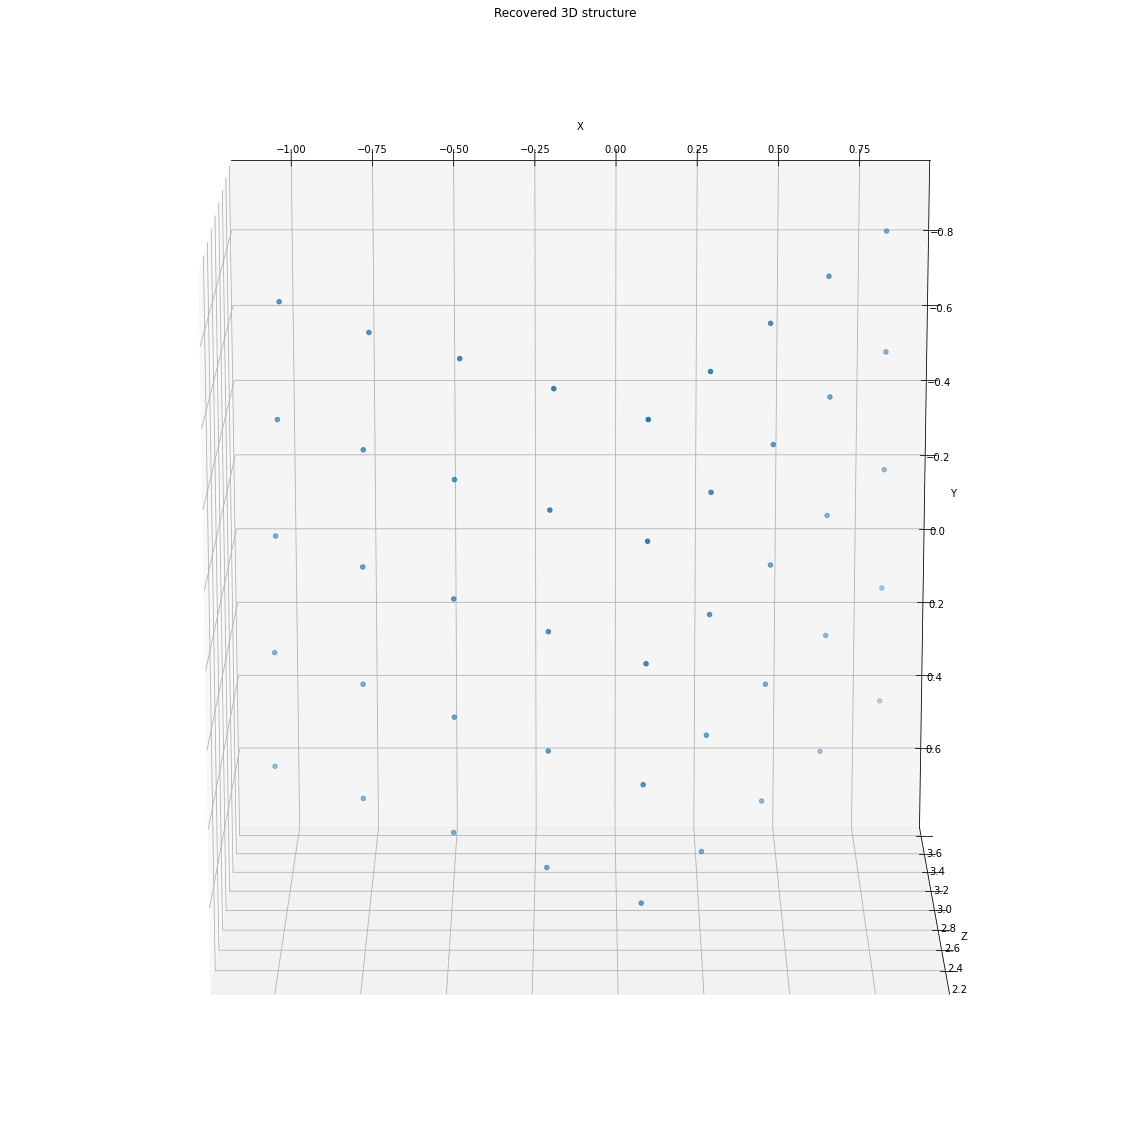

In [51]:
plt.figure(figsize = (20, 25))
ax = plt.axes(projection='3d')
ax.scatter(X.T[0], X.T[1], X.T[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(-75, 270)
plt.title("Recovered 3D structure")
plt.savefig("result_task4")

The performance of the result is good enough to give an idea about shape and depth (which points are closer to the camera etc.). The problem with the result is that corresponding points which are reconstructed are too few to reconstruct the object. Dense feature matching techniques are necessary to obtain a good reconstruction of the object (as opposed to the result in this case where only the ideas on shape and depth are obtained). Possible sources of error are: 

* The errors when matching corresponding points if any
* The errors of the intrinsic camera matrix if any
* The errors during 8-pt algorithm and triangulation (Both of these algorithms use linear least squares approximations; therefore, it may be possible to reduce the errors of the results using their iterative optimization versions - which are currently used in real applications containing these classical methods)

## Task 5: Dense Correspondence with RANSAC and 3D Reconstruction (EXTRA)

### Are you satisfied with your 3D reconstruction? If not, in order to improve the reconstruction, you can go for a dense correspondence matching between the two views (by your favorite dense feature extraction and matching scheme such as SURF), eliminate the outliers by RANSAC, perform your triangulation on the resulting dense set of points and visualize the result by fitting a mesh surface to your 3D point cloud. Visualize/print your result from different render viewpoints. Then you can even try to color your mesh by texture mapping.

Dense correspondence matching via sift etc is not supported in opencv python versions greater than 2. Therefore standard Oriented FAST and Rotated BRIEF (ORB) is used. 2 results are shown below, 1 for without RANSAC, 1 with RANSAC.

In [52]:
orb = cv2.ORB_create()

In [53]:
keypoints_1, descriptors_1 = orb.detectAndCompute(cube1, None)
keypoints_2, descriptors_2 = orb.detectAndCompute(cube2, None)

In [54]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(descriptors_1, descriptors_2)

matches = sorted(matches, key = lambda x : x.distance)


In [55]:
query = [[keypoints_1[match.queryIdx].pt[0], keypoints_1[match.queryIdx].pt[1], 1] for match in matches]
query = np.array(query)
train = [[keypoints_2[match.trainIdx].pt[0], keypoints_2[match.trainIdx].pt[1], 1] for match in matches]
train = np.array(train)

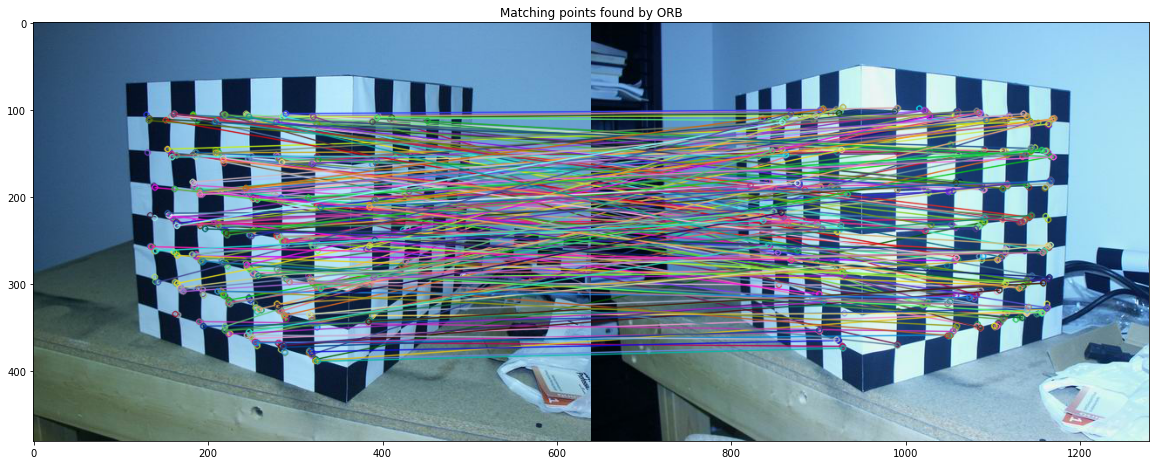

(<matplotlib.image.AxesImage at 0x12956c910>,
 Text(0.5, 1.0, 'Matching points found by ORB'),
 None,
 None)

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(figsize = (20, 25))
img3 = cv2.drawMatches(cube1,keypoints_1,cube2,keypoints_2,matches,None)

plt.imshow(img3,), plt.title("Matching points found by ORB"), plt.show(), plt.savefig("matching_points_task5")

In [57]:
F, mask = cv2.findFundamentalMat(query,train,cv2.FM_RANSAC)

Perform the mask found by RANSAC on the matching points:

In [58]:
pts1 = query[mask.ravel()==1]
pts2 = train[mask.ravel()==1]

In [59]:
len(query), len(pts1)

(242, 17)

In [60]:
new_E = estimate_E(query, train)

In [61]:
u_E, s_E, vt_E = np.linalg.svd(new_E)

In [62]:
new_T1 = from_hat((u_E @ R_p * s_E) @ u_E.T)
new_T2 = from_hat((u_E @ R_n * s_E) @ u_E.T)
new_R1 = (u_E @ R_p.T) @ vt_E
new_R2 = (u_E @ R_n.T) @ vt_E

In [63]:
S1 = naive_depth(X1, X2, new_R1, new_T1)
S2 = naive_depth(X1, X2, new_R1, new_T2)
S3 = naive_depth(X1, X2, new_R2, new_T1)
S4 = naive_depth(X1, X2, new_R2, new_T2)

In [64]:
(S4 < 0).astype(int).sum()

16

S4 gives the least amount of points which do not conform to the depth constraint:

In [65]:
new_P2 = to_P2(new_R2, new_T2, cube_data['Calib'])

In [66]:
new_X = triangulate(query, train, P1, new_P2)

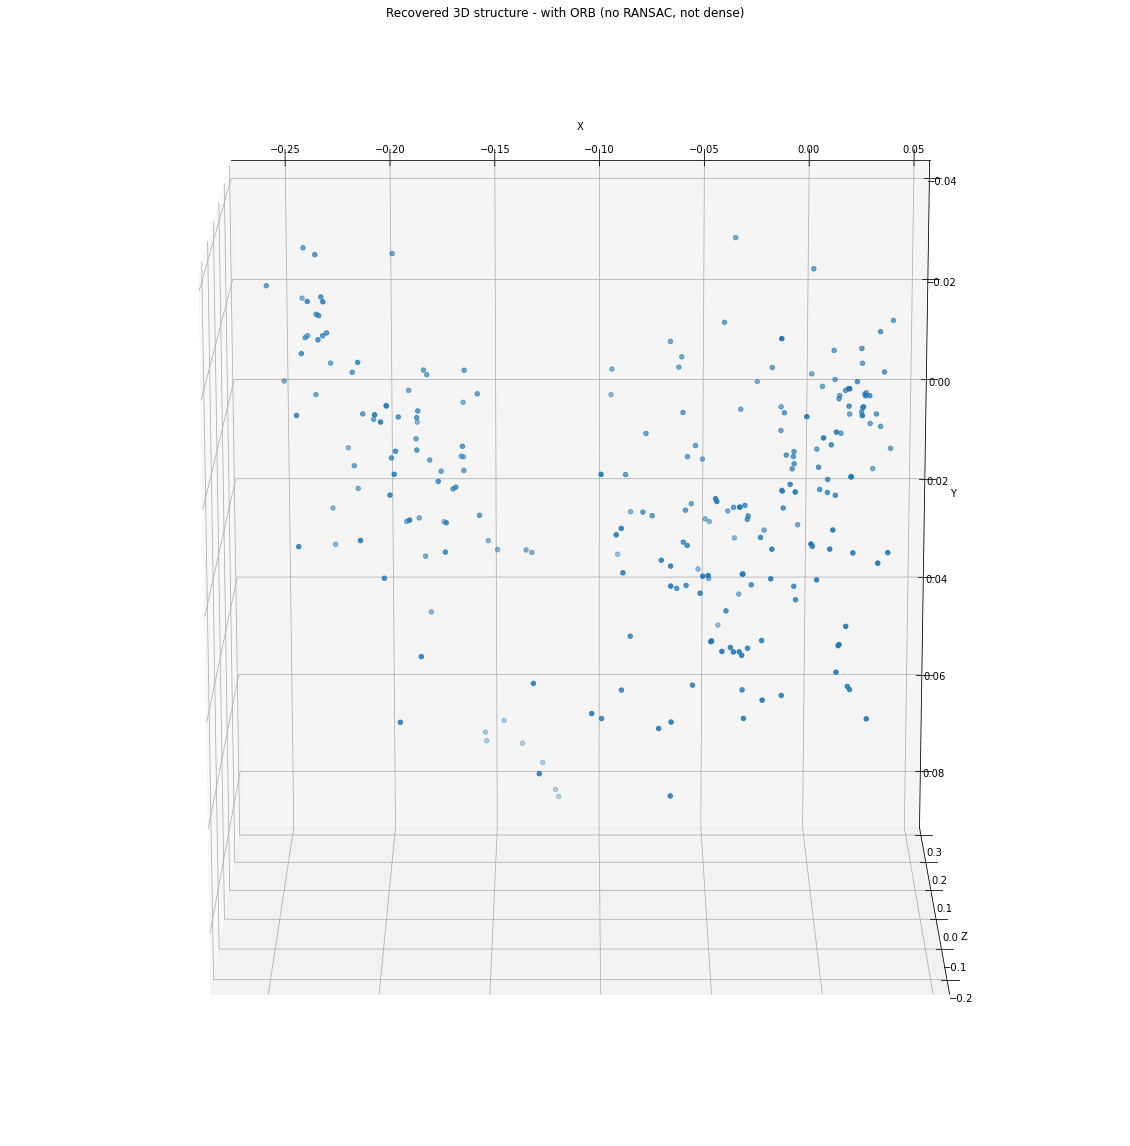

In [67]:
plt.figure(figsize = (20, 25))
ax = plt.axes(projection='3d')
ax.scatter(new_X.T[0], new_X.T[1], new_X.T[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(-75, 270)
plt.title("Recovered 3D structure - with ORB (no RANSAC, not dense)")
plt.savefig("result_task5_1")

This results give a very rough idea on the shape (worse than without ORB).

In [68]:
new_E = estimate_E(pts1, pts2)

In [69]:
u_E, s_E, vt_E = np.linalg.svd(new_E)

In [70]:
new_T1 = from_hat((u_E @ R_p * s_E) @ u_E.T)
new_T2 = from_hat((u_E @ R_n * s_E) @ u_E.T)
new_R1 = (u_E @ R_p.T) @ vt_E
new_R2 = (u_E @ R_n.T) @ vt_E

In [71]:
S1 = naive_depth(X1, X2, new_R1, new_T1)
S2 = naive_depth(X1, X2, new_R1, new_T2)
S3 = naive_depth(X1, X2, new_R2, new_T1)
S4 = naive_depth(X1, X2, new_R2, new_T2)

In [72]:
(S1 < 0).astype(int).sum()

6

S1 gives the least amount of points which do not conform to the depth constraint:

In [73]:
new_P2 = to_P2(new_R1, new_T1, cube_data['Calib'])

In [74]:
new_X = triangulate(pts1, pts2, P1, new_P2)

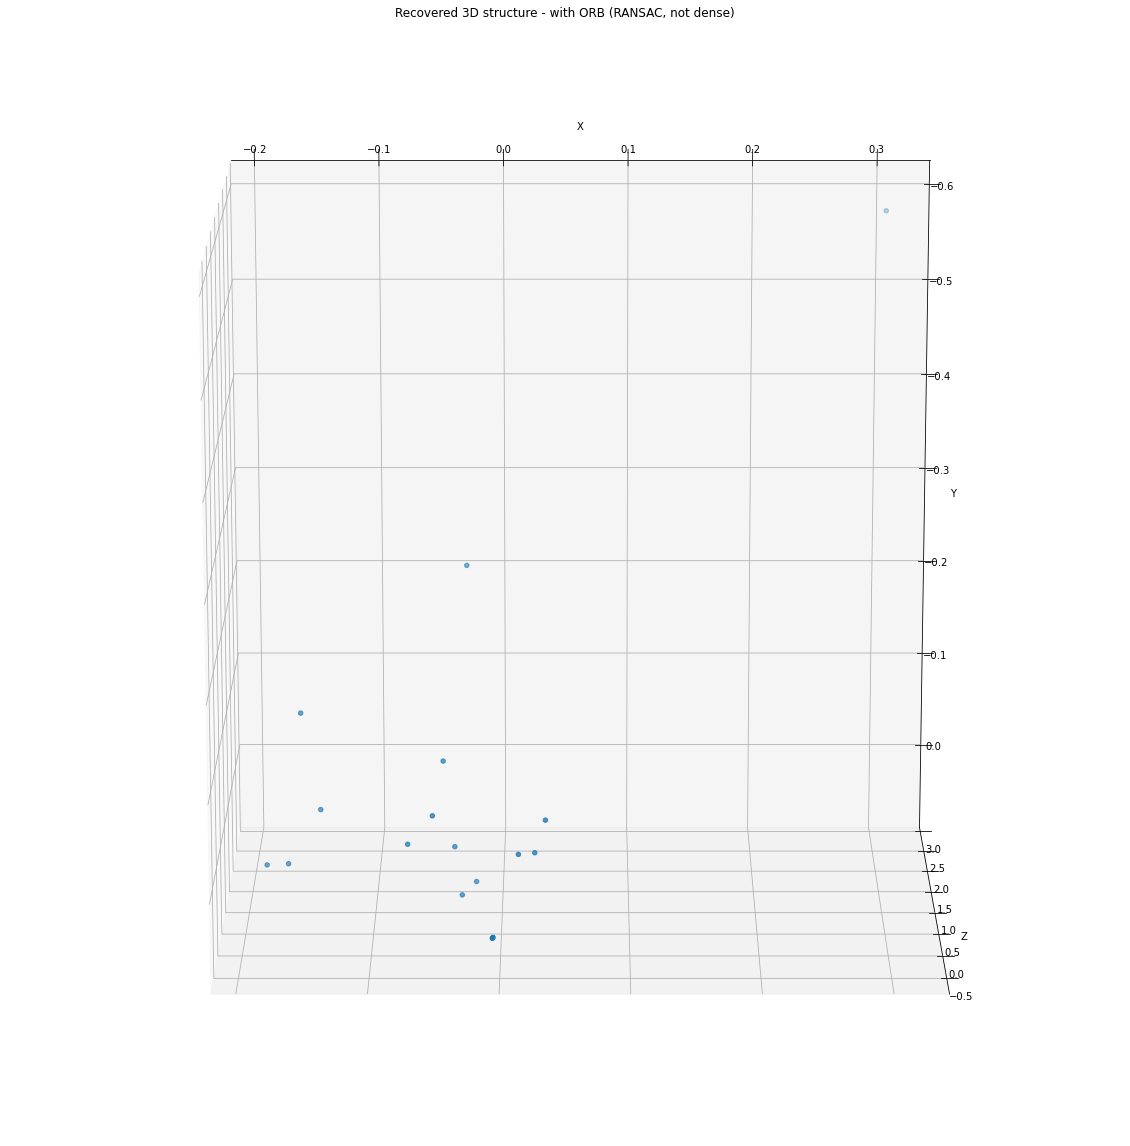

In [75]:
plt.figure(figsize = (20, 25))
ax = plt.axes(projection='3d')
ax.scatter(new_X.T[0], new_X.T[1], new_X.T[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(-75, 270)
plt.title("Recovered 3D structure - with ORB (RANSAC, not dense)")
plt.savefig("result_task5_2")

This results gives no good idea on the image.

Conclusion: Dense feature matching is necessary, hope opencv python provides that again.

Results are insufficient to fit a good mesh surface.